In this case, we will do sentiment analysis for reviews in Indonesian. Sentiment will be divided into three categories, positive, neutral, and negative. Using the train dataset, we will create classification model with Deep Neural Network (DNN) to categorize whether the comments from people belong to positive, negative, or neutral sentiment category. 

## Import Libraries

In [ ]:
# uncomment this if the system do not have nlp-id
!pip install --upgrade nlp-id  

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import keras_tuner as kt
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix
import random
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nlp_id.lemmatizer import Lemmatizer 
from nlp_id.stopword import StopWord 
from tensorflow.keras.models import model_from_json

# generate random seed for model reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings('ignore')

# set the maximum number of columns and rows to display to a large number
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Import Dataset for Train and Validation

In [4]:
train = pd.read_csv('/kaggle/input/dataset-for-indonesian-sentiment-analysis/train_preprocess_ori.tsv', sep='\t')
val = pd.read_csv('/kaggle/input/dataset-for-indonesian-sentiment-analysis/valid_preprocess.tsv', sep='\t')

# source: https://github.com/IndoNLP/indonlu/tree/master/dataset/smsa_doc-sentiment-prosa 

## Exploratory Data Analysis

In [5]:
train.head(20)

,text,sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       11000 non-null  object
 1   sentiment  11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [7]:
# Descriptive Statistics of Text and Sentiment

train.describe()

,text,sentiment
count,11000,11000
unique,10933,3
top,kesal,positive
freq,4,6416


The train dataset contains 11000 entries. We have a word 'kesal' 4 times in text feature, which means we have duplicate values in the dataset. We will handle this later in data preprocessing section. 

### Sentiment Distribution

We will check the sentiment distribution in the train dataset. 

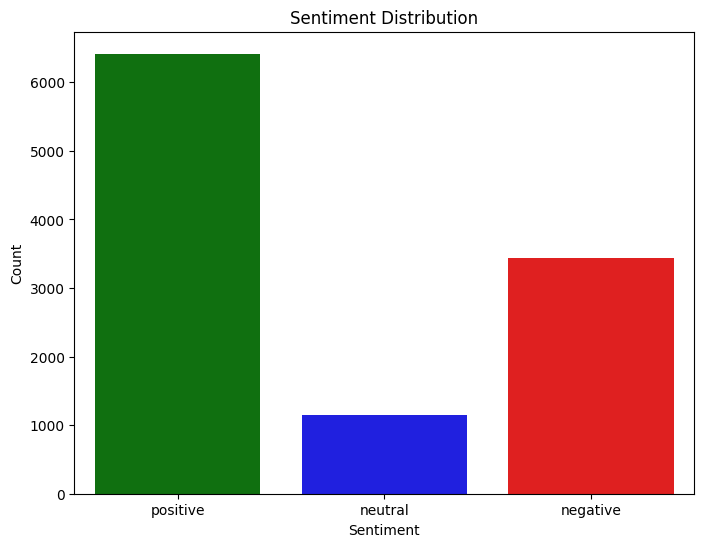

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(x = train['sentiment'], palette = ['g','b','r'])
plt.title('Sentiment Distribution')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.show()

In [9]:
sentiment_distribution = train['sentiment'].value_counts()
print("\Sentiment Distribution Count:")
print(sentiment_distribution)

\Sentiment Distribution Count:
sentiment
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64


As we can see, the comment is dominated with positive sentiment with more than 6000 entries. Negative sentiment has around 3500 entries, while neutral sentiment has around 1000. The sentiment has imbalance data, because only small portion of neutral sentiment available in the dataset. We will handle this imbalance later.

In addition, we will add the amount of character length to have better understanding of the text distribution.

In [10]:
train['character_length'] = train['text'].apply(lambda x: len(x))
print("\nDescriptive Statistics of Character Length:")
print(train['character_length'].describe())


Descriptive Statistics of Character Length:
count    11000.000000
mean       188.896909
std        121.082093
min          3.000000
25%         89.000000
50%        160.000000
75%        276.000000
max        567.000000
Name: character_length, dtype: float64


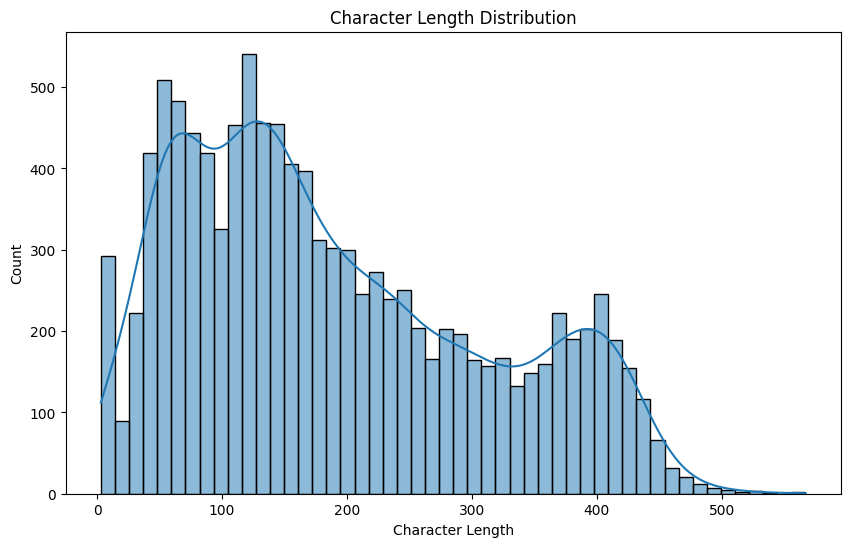

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(train['character_length'], bins=50, kde=True)
plt.title('Character Length Distribution')
plt.xlabel('Character Length')
plt.ylabel('Count')
plt.show()

The character length is around 50 - 150 for all sentences. 

<Axes: xlabel='character_length', ylabel='Density'>

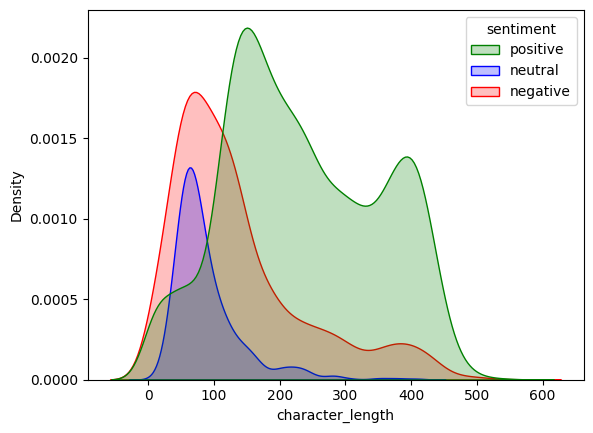

In [12]:
# Character Length Distribution based on Sentiment

sns.kdeplot(data = train, x='character_length', hue='sentiment', palette = ['g','b','r'], fill=True)

As we can see, the longer sentences tend to have positive sentiment, while most shorter sentences have neutral and negative sentiment. 

### Checking The 20 Most Common Words for Positive, Neutral, and Negative Sentiment

In [13]:
def plot_top_words(sentiment, stop_words=None):
    subset = train[train['sentiment'] == sentiment]
    text = ' '.join(subset['text'])
    cv = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words)
    cv_fit = cv.fit_transform(subset['text'])
    word_freq = pd.DataFrame(cv_fit.toarray(), columns=cv.get_feature_names_out())
    word_freq_sum = word_freq.sum().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(y=word_freq_sum.head(20).index, x=word_freq_sum.head(20).values)
    plt.title(f'Top 20 Words {sentiment} sentiment')
    plt.ylabel('Words')
    plt.xlabel('Frequency')
    plt.show()

- In the initial analysis, we will explore the data as is without manipulation and preprocessing.
- We will use combination of unigram and bigram for vectorizer, because we want to preserve the context from sentences.
- The model will be better at recognize pattern if we use bigram, such as "tidak enak" to categorized as negative sentiment. The model cannot understand the context of the sentence if we use unigram. 


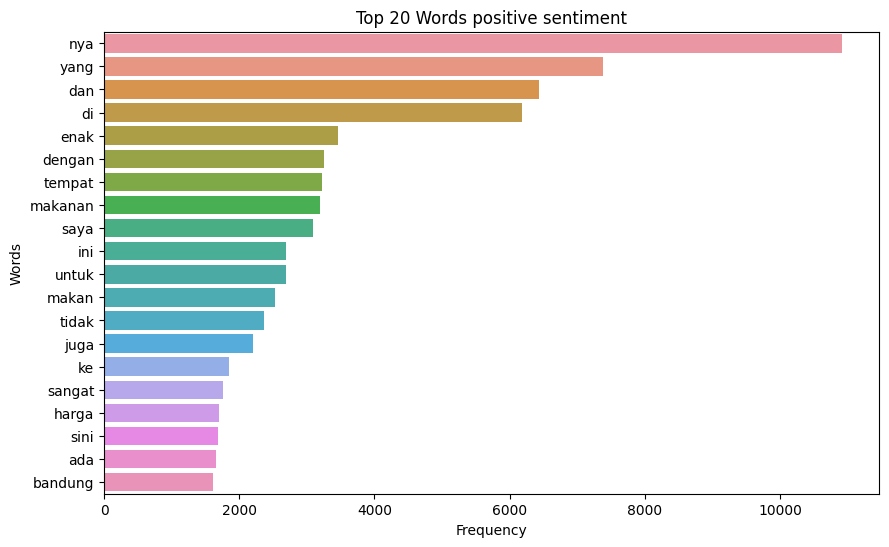

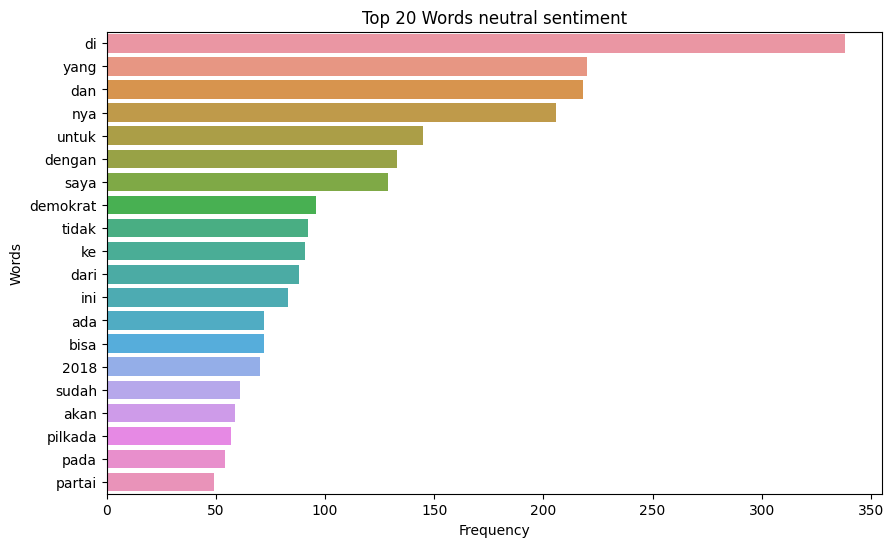

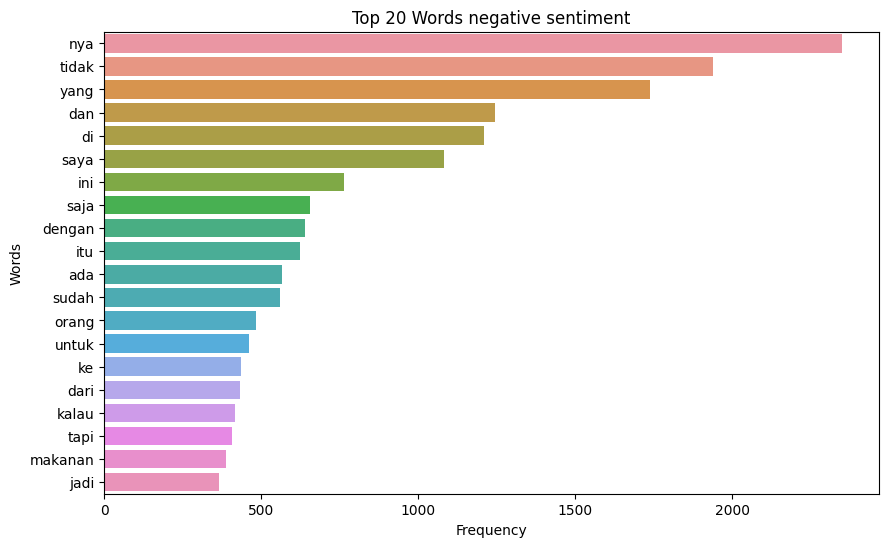

In [14]:
plot_top_words('positive')
plot_top_words('neutral')
plot_top_words('negative')

- Based on the 20 most frequent data in positive, neutral, and negative, there are still many common words in Indonesian that are insignifant for analysis, such as di, ke, nya, which are preposition in Indonesian. 
- We will use stop words to remove common words in Indonesian.
- We will also use lemmatization to reduce redundance words that have same meaning, such as "makan" and "makanan" that have the similar meaning. 

In [15]:
## list of Indonesian stop words

stopword = StopWord() 
stopword.get_stopword() 

indonesian_stop_words = stopword.get_stopword() 

indonesian_stop_words

['ada',
 'adalagi',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agak-agak',
 'agaknya',
 'agar',
 'aja',
 'akan',
 'akankah',
 'akankan',
 'akhir',
 'akhir-akhirnya',
 'akhirannya',
 'akhiri',
 'akhirinya',
 'akhirnya',
 'aku',
 'akulah',
 'akunya',
 'akurat',
 'akutu',
 'ala',
 'alamak',
 'alhamdulillah',
 'alhasil',
 'amat',
 'amat-amat',
 'amatlah',
 'anda',
 'anda-anda',
 'andai',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apa-apanya',
 'apaan',
 'apabila',
 'apaitu',
 'apakah',
 'apalagi',
 'apanya',
 'apasaja',
 'apatah',
 'apesnya',
 'arah',
 'artinya',
 'asal',
 'asalkan',
 'asumsinya',
 'asumsikan',
 'atas',
 'atas-atas',
 'atas-batas',
 'ataspun',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagi-bagi',
 'bagian',
 'bagikan',
 'bahasakan',
 'bahasanya',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bak',
 'bakal',
 'bakal-bakal',
 'bakalan',
 'balik',
 'balikan',
 'balikk

In [16]:
def clean_text(text):
    # to lowercase text, remove text in square brackets, links, punctuation, and numbers.
    import re
    import string
    text = str(text).lower()
    text = re.sub('\[/(){}\[\]\|@,;]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# apply clean text to text
train['text'] = train['text'].apply(lambda x:clean_text(x))

val_for_model_evaluation = val.copy() # for model evaluation purpose

val['text'] = val['text'].apply(lambda x:clean_text(x))

In [17]:
# Lemmatizer to make the words become their base form

lemmatizer = Lemmatizer() 
def lemmatization(text):
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word in text)
    return text
# Buat kolom tambahan untuk data description yang telah dilemmatization   
train['text'] = train['text'].apply(lemmatization)
val['text'] = val['text'].apply(lemmatization)

In [18]:
# checking text after cleaning and lemmatize handling
 
train.head(20)

,text,sentiment,character_length
0,warung ini milik oleh usaha pabrik tahu yang s...,positive,404
1,mohon ulama lurus dan mmbri hujjah partai apa ...,neutral,102
2,lokasi strategis di jalan sumatera bandung tem...,positive,184
3,betapa bahagia nya diri ini saat unboxing pake...,positive,93
4,duh jadi mahasiswa jangan sombong dong kasih k...,negative,214
5,makan agam harga makan di food stall akan tamb...,positive,161
6,pakai kartu kredit bca tidak untung malah rugi...,negative,52
7,tempat unik bagus buat foto makan enak pegawai...,positive,227
8,saya sama keluarga baru saja nikmat alam kulin...,positive,391
9,syukur,positive,9


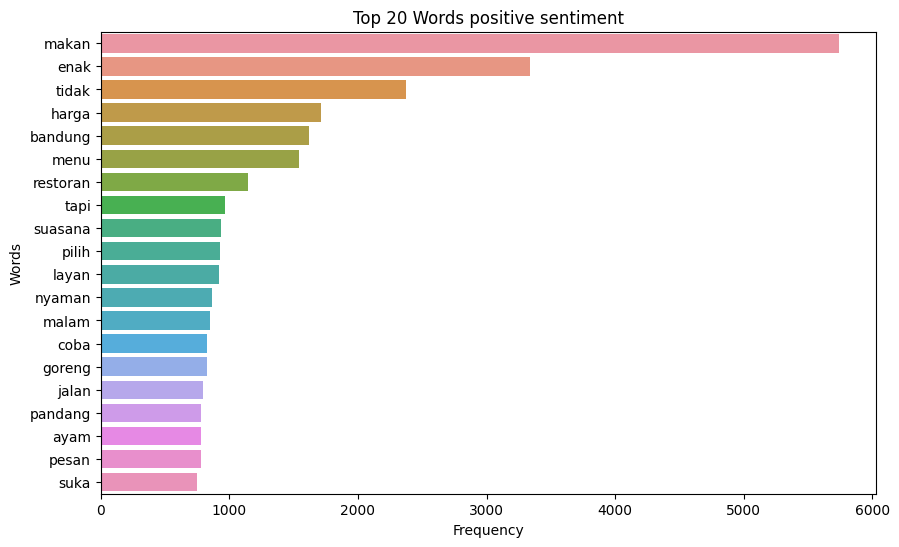

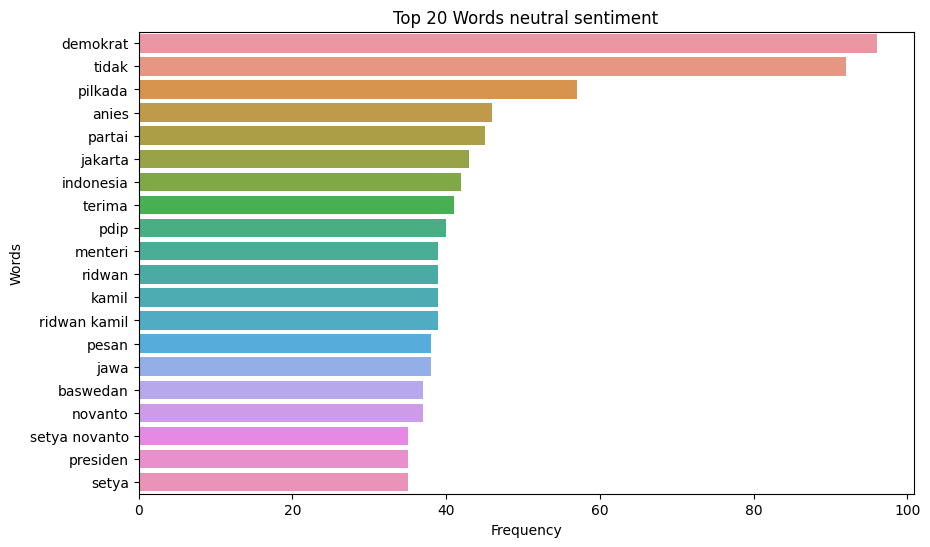

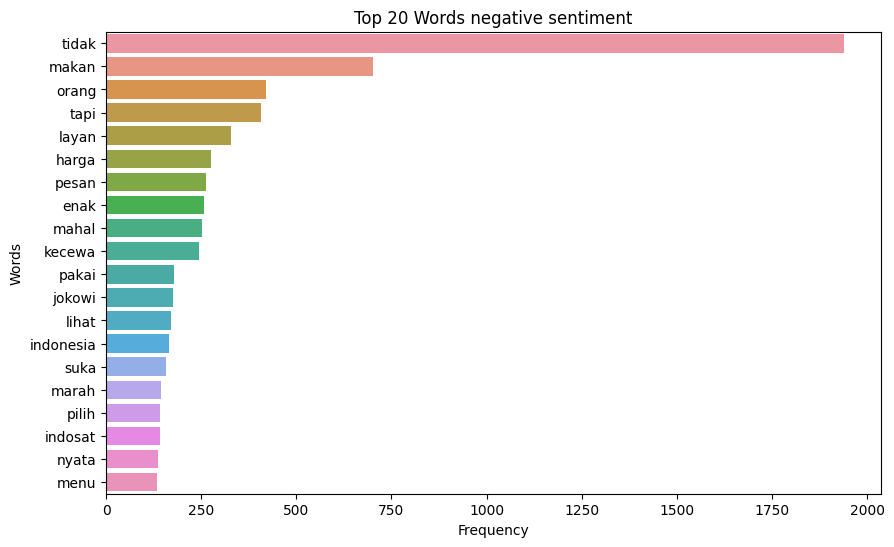

In [19]:
# we also add some common words that are not included in Indonesian stop words. 

additional_stop_words = ['nya', 'ya', 'sih', 'baiknya', 
                        'berkali', 'kali', 'kurangnya', 'mata', 'gue',
                        'olah', 'sekurang', 'setidak', 'tama', 'tidaknya', 'banget'
                        ]

# Combine Indonesian stop words from library and additional stop words
combined_stop_words = list(indonesian_stop_words) + additional_stop_words

# retain "tidak" and "tapi" because this word have strong meaning in sentence context, and appear in top 20 most words
combined_stop_words.remove('tidak')
combined_stop_words.remove('tapi')

plot_top_words('positive', stop_words=combined_stop_words)
plot_top_words('neutral', stop_words=combined_stop_words)
plot_top_words('negative', stop_words=combined_stop_words)

After cleaning the dataset, only specific words appear in the top 20 words without noise. 

## Data Preprocessing and Feature Engineering

### Check Missing Values

In [20]:
train.isna().any()

text                False
sentiment           False
character_length    False
dtype: bool

There are no missing values found in the dataset. 

In [21]:
train.duplicated().sum()

67

In [22]:
train[train.duplicated(keep=False)==True].head(10)

,text,sentiment,character_length
9,syukur,positive,9
69,marah,negative,5
109,jangan pernah kecewa dengan apa yang beri oleh...,positive,57
140,dasar gubernur tidak mutu pecat saja dari gube...,negative,57
166,jokowi tidak suka sebar isu bohong,positive,34
266,berantak,negative,10
344,maklum pak belah pola fikir nya sempit yang ad...,negative,76
802,sempat nikmat santap pagi karena sedang inap d...,positive,442
913,sudah lama dibaned kalau pakai telkom dan telk...,negative,100
948,berantak,negative,10


There are 67 duplicate values in the dataset, we will remove the duplicated values.

In [23]:
train.drop_duplicates(inplace=True)

In [24]:
train.duplicated().sum()

0

There is no more duplicated values in the dataset.

## Model Creation and Evaluation

In [25]:
stop_words = combined_stop_words

# vectorized words using TF-IDF

vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words=stop_words)
X_train = vectorizer.fit_transform(train['text']).toarray()
X_val = vectorizer.transform(val['text']).toarray()

# Encode labels for sentiment
encoder = LabelEncoder()
y_train = encoder.fit_transform(train['sentiment'])
y_val = encoder.transform(val['sentiment'])

In [26]:
# encoder results

encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

### Base Model without Tuning

In [27]:
# use 3 layers and 1 output layer for model 

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(
    units=128,  
    activation='relu',  
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  
))
model.add(tf.keras.layers.Dropout(0.5))  

model.add(tf.keras.layers.Dense(
    units=128,  
    activation='relu',  
    kernel_regularizer=tf.keras.regularizers.l2(0.001) 
))
model.add(tf.keras.layers.Dropout(0.5))  

model.add(tf.keras.layers.Dense(
    units=128,  
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(0.001) 
))
model.add(tf.keras.layers.Dropout(0.5))  

model.add(tf.keras.layers.Dense(3, activation='softmax'))  

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
    

### Handling Data Imbalance

Due to imbalance in sentiment labels, we will use class weight in modelling to make minority have more impact in the calculation. 

In [28]:
# Calculate class weights for sentiment
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val),
                    class_weight=class_weights_dict, callbacks=[early_stopping])


Epoch 1/10
 14/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4295 - loss: 1.4666

I0000 00:00:1719161676.973852     158 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719161676.988139     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6516 - loss: 1.0994

W0000 00:00:1719161687.803506     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


342/342 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.6518 - loss: 1.0990 - val_accuracy: 0.8484 - val_loss: 0.6779
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8409 - loss: 0.7608 - val_accuracy: 0.8667 - val_loss: 0.7525
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9406 - loss: 0.5428 - val_accuracy: 0.8738 - val_loss: 0.7939
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9592 - loss: 0.4805 - val_accuracy: 0.8738 - val_loss: 0.8173


In [29]:
# Evaluate the model

loss, accuracy = model.evaluate(X_val, y_val)
print(f'Loss: {loss}, Accuracy: {accuracy}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8590 - loss: 0.6646
Loss: 0.677947461605072, Accuracy: 0.8484126925468445


As we can see, the model tend to overfit, and validation loss is also increased as epoch increase. We will improve the model by doing hyperparameter tuning in the next section. 

In [30]:
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=1)

26/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

W0000 00:00:1719161704.848400     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


### Model Evaluation without Tuning

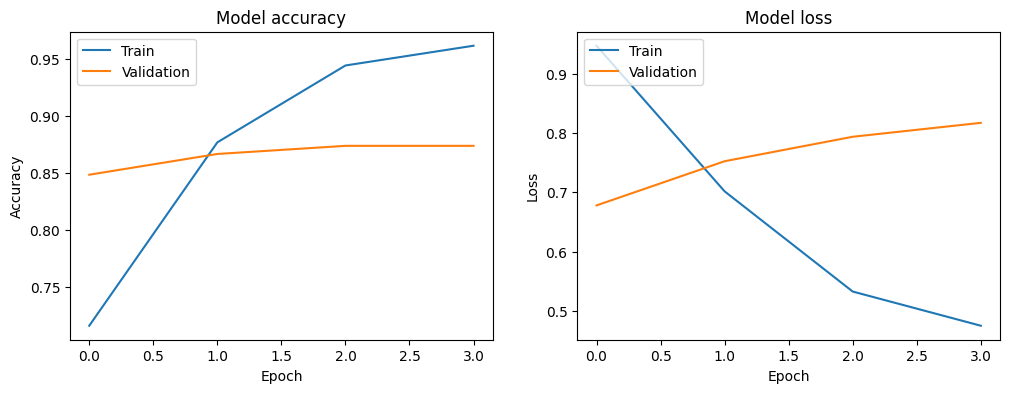

In [31]:
# visualization for model training process per epoch

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Classification Report

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       394
           1       0.68      0.65      0.66       131
           2       0.91      0.91      0.91       735

    accuracy                           0.85      1260
   macro avg       0.79      0.79      0.79      1260
weighted avg       0.85      0.85      0.85      1260



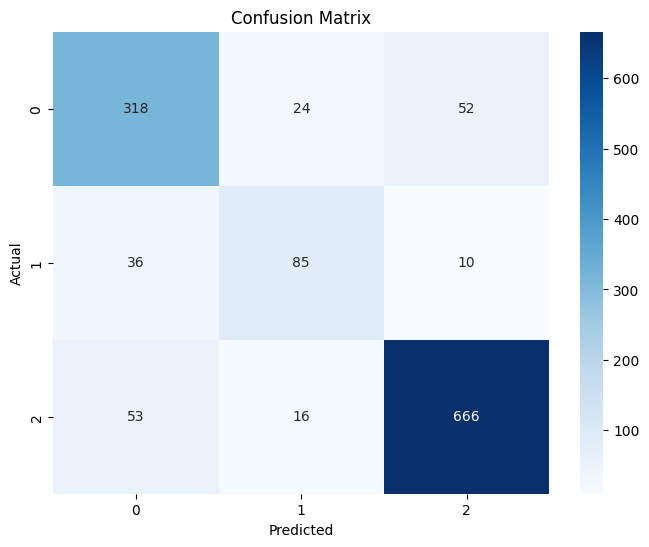

In [32]:
print(classification_report(y_val, y_pred_classes))

conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The model is actually quite good with accuracy = 0.83 and f1-score = 0.90. However, the model still have overfit issue and have high validation loss value. We will handle this issue with hyperparameter tuning. 

## Hyperparameter Tuning

In [33]:
# create function for hyperparameter tuning
# units, regularizer, dropout, and learning rate will be tuned.

def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(
        units= hp.Int('units_1', min_value=32, max_value=256, step=16),
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_1', min_value=0.001, max_value=0.01, sampling='log'))
    ))

    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.9, step=0.1)
    ))
    model.add(tf.keras.layers.Dense(
        units= hp.Int('units_2', min_value=32, max_value=256, step=16),
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_2', min_value=0.001, max_value=0.01, sampling='log'))
    ))

    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.9, step=0.1)
    ))
    model.add(tf.keras.layers.Dense(
        units= hp.Int('units_3', min_value=32, max_value=256, step=16),
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_3', min_value=0.001, max_value=0.01, sampling='log'))
    ))


    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.9, step=0.1)
    ))    
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    learning_rate= hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [34]:
# Create a tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=2,
    factor= 2, 
    directory='my_dir',
    project_name='sentiment_analysis'
)

# Search for best hyperparameter
tuner.search(X_train, y_train, epochs=25, validation_data=(X_val, y_val), class_weight=class_weights_dict)

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the best model based on the best hyperparameter
history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weights_dict)

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Predict on validation data
y_pred = best_model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=1)

Trial 3 Complete [00h 00m 28s]
val_accuracy: 0.7396825551986694

Best val_accuracy So Far: 0.7396825551986694
Total elapsed time: 00h 01m 30s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
48                |96                |units_1
0.0035819         |0.0031501         |l2_1
0.2               |0.5               |dropout_rate
144               |176               |units_2
0.001952          |0.0014156         |l2_2
256               |144               |units_3
0.004863          |0.008584          |l2_3
0.00016184        |0.025435          |lr
2                 |2                 |tuner/epochs
0                 |1                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/2
342/342 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6874 - loss: 1.0474 - val_accuracy: 0.8254 - val_loss: 0.7339
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8446 - loss

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │    13,384,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,253,963 (153.56 MB)

 Trainable params: 13,417,987 (51.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,835,976 (102.37 MB)

In [36]:
# Best hyperparameters values

print("Best Hyperparameters:")
best_hps.values

Best Hyperparameters:


{'units_1': 48,
 'l2_1': 0.0035818619055928693,
 'dropout_rate': 0.2,
 'units_2': 144,
 'l2_2': 0.0019520295378549141,
 'units_3': 256,
 'l2_3': 0.004863012528399407,
 'lr': 0.00016183555783356757,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

### Model Evaluation after Hyperparameter Tuning

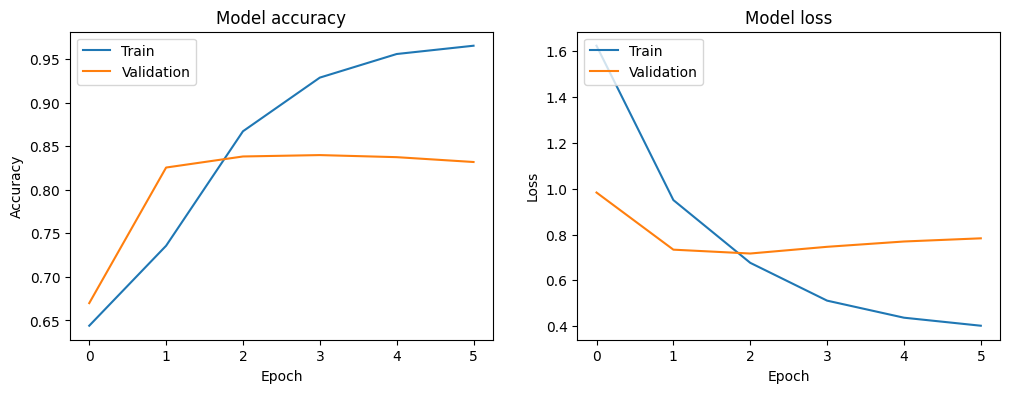

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       394
           1       0.78      0.56      0.65       131
           2       0.90      0.92      0.91       735

    accuracy                           0.84      1260
   macro avg       0.81      0.75      0.77      1260
weighted avg       0.84      0.84      0.84      1260



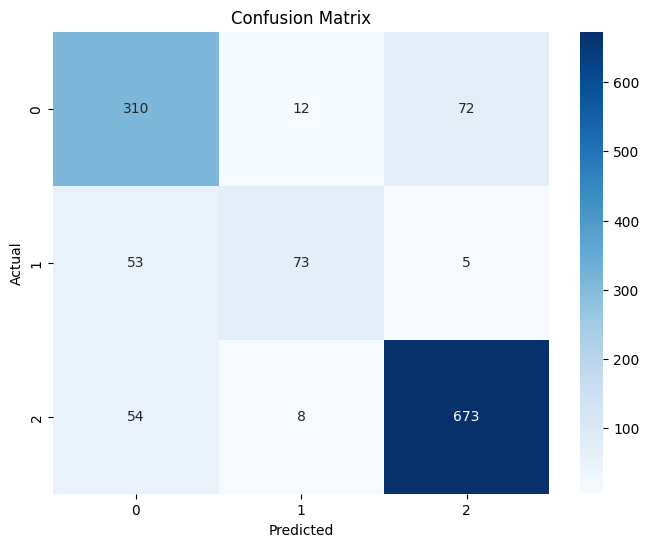

In [38]:
print(classification_report(y_val, y_pred_classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

After hyperparameter tuning, the model is improved from before, with accuracy = 0.85 and f1-score = 0.91. The model also have no overfit issue anymore, with smooth learning curve as the model has gradual increase of accuracy and gradual decrease of loss during epoch increment.

## Model Evaluation from Prediction Results

In [39]:
# Matching the prediction results with the ground truth from the dataset

correct_predictions_df = val_for_model_evaluation.iloc[y_val == y_pred_classes]
incorrect_predictions_df = val_for_model_evaluation.iloc[y_val != y_pred_classes]

In [40]:
# show 5 examples of sentences with correct prediction

print("Correct Predictions:")
for index, row in correct_predictions_df.head().iterrows():
    print(f"Text: {row['text']}")  
    print(f"Actual Label: {row['sentiment']}")  
    print(f"Predicted Label: {encoder.classes_[y_pred_classes[index]]}")  
    print()

Correct Predictions:
Text: tidak enak
Actual Label: negative
Predicted Label: negative

Text: restoran ini menawarkan makanan sunda . kami memesan ayam goreng , kangkung , sayur asam , ikan gurame goreng , ikan bakar , nasi goreng , karedok , tahu tempe , nasi putih , nasi merah etc minuman yang mereka tawarkan juga cukup variatif . rasa makanan enak dan harga murah . kami 9 dewasa dan 5 anak kecil , hanya menghabiskan 800,000
Actual Label: positive
Predicted Label: positive

Text: lokasi di alun alun masakan padang ini cukup terkenal dengan kepala ikan kakap gule , biasa saya pesan nasi bungkus padang berisikan rendang , ayam pop dan perkedel . porsi banyak dan mengenyangkan
Actual Label: positive
Predicted Label: positive

Text: betapa bejad kader gerindra yang anggota dprd mencabuli anak smp , rakyat harus cerdas partai mana yang harus di tengelamkan di 2019
Actual Label: negative
Predicted Label: negative

Text: kampiun bistro berada di jalan . kebon kawung , sebelah kanan seberang

Evaluation for correct prediction:

- The model can correctly predict "tidak enak" sentence, which is negation in Indonesian words. It seems that the use of bigram during modelling is effective to recognize the context of the sentences.
- Sentences that talk about food or "makan" in Indonesian tend to have positive sentiment, and this is depicted in the prediction. This is align with the analysis of top 20 words, with "makan" being one of the top 20 in positive sentiment. 

In [41]:
# show 5 examples of sentences with incorrect prediction

print("Incorrect Predictions:")
for index, row in incorrect_predictions_df.head().iterrows():
    print(f"Text: {row['text']}") 
    print(f"Actual Label: {row['sentiment']}") 
    print(f"Predicted Label: {encoder.classes_[y_pred_classes[index]]}") 
    print() 


Incorrect Predictions:
Text: meski masa kampanye sudah selesai , bukan berati habis pula upaya mengerek tingkat kedipilihan elektabilitas .
Actual Label: neutral
Predicted Label: negative

Text: kamar nya sempit tidak ada tempat menyimpan barang malah menambah barang . by the way ini kipas2 mau diletakkan mana . mana uchiwa segede ini pula .
Actual Label: negative
Predicted Label: positive

Text: yusri seorang ibu yang tidak tahu diri . sudah tidak punya uang mebel lagi . melihat muka ibu dikaca . sudah dibantu tidak terima kasih . dasar maling .
Actual Label: negative
Predicted Label: positive

Text: trans corp kembali berniat membuka transmart
Actual Label: neutral
Predicted Label: negative

Text: : kalau subscriber youtube netmediatama mencapai 1 juta .
Actual Label: neutral
Predicted Label: negative



Evaluation for incorrect prediction:

- The model have some difficulties in predicting short sentences such as sentence 2 and 3 in the example. The model tends to classify short sentences as negative sentiment. 
- In sentence 4, it looks like the sentence have negative sentiment, as it has double negation ("namun" and "tapi") in one sentence. It might be the reason why the model classify the sentence as negative sentiment. 
- Even though the model can recognize "tidak enak" in correct prediction before, the model is unable to recognize "tidak pernah kapok" in the last example of incorrect prediction. Maybe the model treat this as negative sentiment because of "tidak pernah". If the model can recognize "tidak pernah kapok", maybe the model can have correct prediction. 

## Save Model

In [42]:
# Serialize model to JSON:

model_json = best_model.to_json()
with open("nlp_model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5 (h5py needed):

best_model.save_weights("nlp_model.weights.h5")
print("Model saved to disk.")

Model saved to disk.


## Load Model

In [43]:
json_file = open('nlp_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into loaded model:
loaded_model.load_weights("nlp_model.weights.h5")
print("Model loaded from disk.")

Model loaded from disk.


## Recommendation Action

1. Before using stop words, ensure that the words removed are not critical in text understanding. In this case, by excluding "tidak" from stop words, the model can understand the context of the sentences better. If we use the Indonesian stop words as is, we will lose the "tidak" word, which may decrease our model performance in general. The model can no longer recognize negation context if we remove the word. 
2. Doing more experiments to increase model performance, such as using trigram for vectorizer, or modify the range of value and parameter used during hyperparameter tuning. 
3. Try other models such as RNN/LSTM to have better understanding in text context and sequence. 
4. Try other methods for handling data imbalance instead of class weight, or add more dataset to improve model learning. 

Thank you for exploring my notebook! I hope you found it informative and that it enriched your knowledge. If you have any questions, suggestions, or feedback, please do not hesitate to reach out. I genuinely value your input! 📘✨

If you found this notebook helpful, I would greatly appreciate an upvote. Your support encourages me to continue creating more high-quality content! 👍😊